## DataLoader class and data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from jetnet.datasets import JetNet
from jetnet.utils import to_image
import numpy as np
from sklearn.preprocessing import OneHotEncoder

class DataLoader:
  def __init__(self):
    pass

  def get_data(num_images=70000, Raggio = 0.4, LAST=False, SAVE = False):
    ''' DOWNLOAD DATA '''
    #set args to load the data
    data_args = {
        "jet_type": ["g", "q", "t", "w", "z"],
        # ‘g’ (gluon), ‘q’ (light quarks), ‘t’ (top quarks), ‘w’ (W bosons), or ‘z’ (Z bosons)
        "data_dir": "datasets/jetnet",
        # only selecting the kinematic features
        "particle_features": ["etarel", "phirel", "ptrel"],
        "num_particles": 30,
        "jet_features": ["type"],
        "download": False,
        "split": "all",
    }

    # download as numpy arrays
    particle_data, jet_data = JetNet.getData(**data_args)

    ''' TRANSFORM TO IMAGES '''
    im_size = 50 #pixel size of the length of the image
    maxR=Raggio #maximum radius of the jet
    if LAST == True:
      X_train = np.array( [to_image(particle_data[len(particle_data) - num_images + i], im_size, maxR=maxR) for i in range(num_images)] )
      Y_train = jet_data[-num_images:]
    else:
      X_train = np.array( [to_image(particle_data[i], im_size, maxR=maxR) for i in range(num_images)] )
      Y_train = jet_data[:num_images]

    if SAVE and LAST:
      np.savez("X_test_N" + str(num_images) + "_lpx" + str(im_size) + "_gqtwz", X_train)
      np.savez("Y_test_N" + str(num_images) + "_lpx" + str(im_size) + "_gqtwz", Y_train)
    elif SAVE:
      np.savez("X_N" + str(num_images) + "_lpx" + str(im_size) + "_gqtwz", X_train)
      np.savez("Y_N" + str(num_images) + "_lpx" + str(im_size) + "_gqtwz", Y_train)

    return X_train, Y_train

  def get_data_onehot(train=42000, valid=14000, test=14000, Raggio= 0.4, SAVE = False):
    X_Data, Y_Data = DataLoader.get_data(train+valid, Raggio=Raggio, SAVE = SAVE)
    # data split

    X_train, X_val = X_Data[:train], X_Data[train:]
    Y_train, Y_val = Y_Data[:train], Y_Data[train:]

    X_test, Y_test = DataLoader.get_data(test, Raggio=Raggio, LAST=True, SAVE = SAVE)

    # one hot encoding the lables
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    Y_train_onehot = one_hot_encoder.fit_transform(Y_train.reshape((-1,1)))
    Y_valid_onehot = one_hot_encoder.fit_transform(Y_val.reshape((-1,1)))
    Y_test_onehot = one_hot_encoder.fit_transform(Y_test.reshape((-1,1)))

    return X_train, X_val, X_test, Y_train_onehot, Y_valid_onehot, Y_test_onehot

2025-01-24 17:18:03.615806: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-24 17:18:03.643696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-24 17:18:03.658717: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-24 17:18:03.663343: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 17:18:03.674689: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Data loading
X_train, X_val, X_test, Y_train_onehot, Y_valid_onehot, Y_test_onehot = DataLoader.get_data_onehot(train=200000, valid=50000, test=50000, Raggio = 0.1)

## ModelEval class

In [ ]:
plt.rcParams.update({
    "font.family": "FreeSerif",
    "axes.labelsize": 15,
    "font.size": 15,
    "legend.fontsize": 10,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15
})

class ModelEval:
  def __init__(self, model, X_test_set, Y_test_set, model_str="model", cmap='inferno'):
    self.X_test = X_test_set
    self.Y_test = Y_test_set
    self.cmap = cmap
    self.model_str = model_str
    self.model = model
    self.array_labels = ["gluon", "light\nquarks", "top\nquark", "W boson", "Z boson"]

    self.Y_test_pred = self.model.predict(self.X_test)
    self.Y_test_pred_classes = np.argmax(self.Y_test_pred, axis=1)
    self.Y_test_classes = np.argmax(self.Y_test, axis=1)

  def Conf_Matrix_and_ROC_curve(self):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), dpi=200)
    plt.subplots_adjust(wspace=0.3)

    ''' Confusion Matrix '''
    from sklearn.metrics import confusion_matrix

    conf_m = confusion_matrix(self.Y_test_classes, self.Y_test_pred_classes)
    print("Confusion matrix of " + self.model_str)

    mappable = ax[0].matshow(conf_m, cmap=self.cmap)
    ax[0].set_title("Confusion matrix of " + self.model_str, pad=20)
    ax[0].set_xlabel("Predicted class", labelpad=10)
    ax[0].set_ylabel("True class")
    ax[0].set_xticks(range(5), self.array_labels)
    ax[0].set_yticks(range(5), self.array_labels)
    ax[0].set_aspect('equal')
    fig.colorbar(mappable=mappable, ax=ax[0], shrink=0.85)
    ax[0].xaxis.set_ticks_position("bottom")

    # Add text annotations for each element
    for i in range(conf_m.shape[0]):
        for j in range(conf_m.shape[1]):
            text = ax[0].text(j, i, conf_m[i, j], ha="center", va="center", color="green")

    ''' ROC Curve '''
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score

    for i in range(5):
      fpr, tpr, thresholds = roc_curve(self.Y_test[:,i], self.Y_test_pred[:, i])
      ax[1].plot(fpr, tpr, linewidth=2, label='{0} (area = {1:0.2f})'.format(self.array_labels[i], round(roc_auc_score(self.Y_test[:,i], self.Y_test_pred[:, i]), 5)))

    ax[1].plot([0, 1], [0, 1], 'k--') # dashed diagonal
    ax[1].grid(1)
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title("ROC curve")
    ax[1].legend(fontsize=15)
    ax[1].set_aspect('equal')
    plt.show()

  def accuracy_loss(self, hist):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), dpi=200)
    plt.subplots_adjust(wspace=0.2)

    ax[0].plot(hist['accuracy'], "--", label='Train Accuracy', color="deepskyblue")
    ax[0].plot(hist['val_accuracy'], ".-", label='Validation Accuracy', color="orange")
    ax[0].set_title("Accuracy " + self.model_str, pad=20)
    ax[0].set_xlabel("Epoch", labelpad=10)
    ax[0].legend(fontsize=15)

    ax[1].plot(hist['loss'], "--", label='Train Loss Function', color="deepskyblue")
    ax[1].plot(hist['val_loss'], ".-", label='Validation Loss Function', color="orange")
    ax[1].set_title("Loss function " + self.model_str, pad=20)
    ax[1].set_xlabel("Epoch", labelpad=10)
    ax[1].legend(fontsize=15)
    plt.show()

## ConvNet - definition and fit

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50, 50, 1)),

    tf.keras.layers.Conv2D(filters= 16, kernel_size= 6, strides = 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=6, strides=1),

    tf.keras.layers.Conv2D(filters= 32, kernel_size= 6, strides = 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=6, strides=1),

    tf.keras.layers.Conv2D(filters= 64, kernel_size= 6, strides = 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=6, strides=1),

    tf.keras.layers.Conv2D(filters= 128, kernel_size= 6, strides = 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=6, strides=1),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(5, activation='softmax')
])

model2.summary()

I0000 00:00:1737701740.396209  109036 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737701740.400545  109036 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737701740.400688  109036 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737701740.402814  109036 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 45, 45, 16)     │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 40, 40, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 35, 35, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │        64,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 451,893 (1.72 MB)

 Trainable params: 451,893 (1.72 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics = ["accuracy"]
    )

history = model2.fit(
    X_train, Y_train_onehot,
    batch_size = 128,
    epochs = 40,
    validation_data = (X_val, Y_valid_onehot)
)

Epoch 1/40


I0000 00:00:1737701747.155246  114760 service.cc:146] XLA service 0x77b14c004cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737701747.155279  114760 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-01-24 07:55:47.206648: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-24 07:55:47.350820: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90100


   9/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.2181 - loss: 1.5877

I0000 00:00:1737701751.933749  114760 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 26ms/step - accuracy: 0.4851 - loss: 1.2409 - val_accuracy: 0.5559 - val_loss: 1.1150
Epoch 2/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.5563 - loss: 1.1203 - val_accuracy: 0.5728 - val_loss: 1.0900
Epoch 3/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.5699 - loss: 1.0982 - val_accuracy: 0.5662 - val_loss: 1.0936
Epoch 4/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.5743 - loss: 1.0880 - val_accuracy: 0.5823 - val_loss: 1.0762
Epoch 5/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.5854 - loss: 1.0712 - val_accuracy: 0.5770 - val_loss: 1.0929
Epoch 6/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.5873 - loss: 1.0645 - val_accuracy: 0.5923 - val_loss: 1.0593
Epoch 7/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.5911 - loss: 1.0592 - val_accuracy: 0.5846 - val_loss: 1.0733
Epoch 8/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.5909 - loss: 1.05

## ConvNet - Results

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step


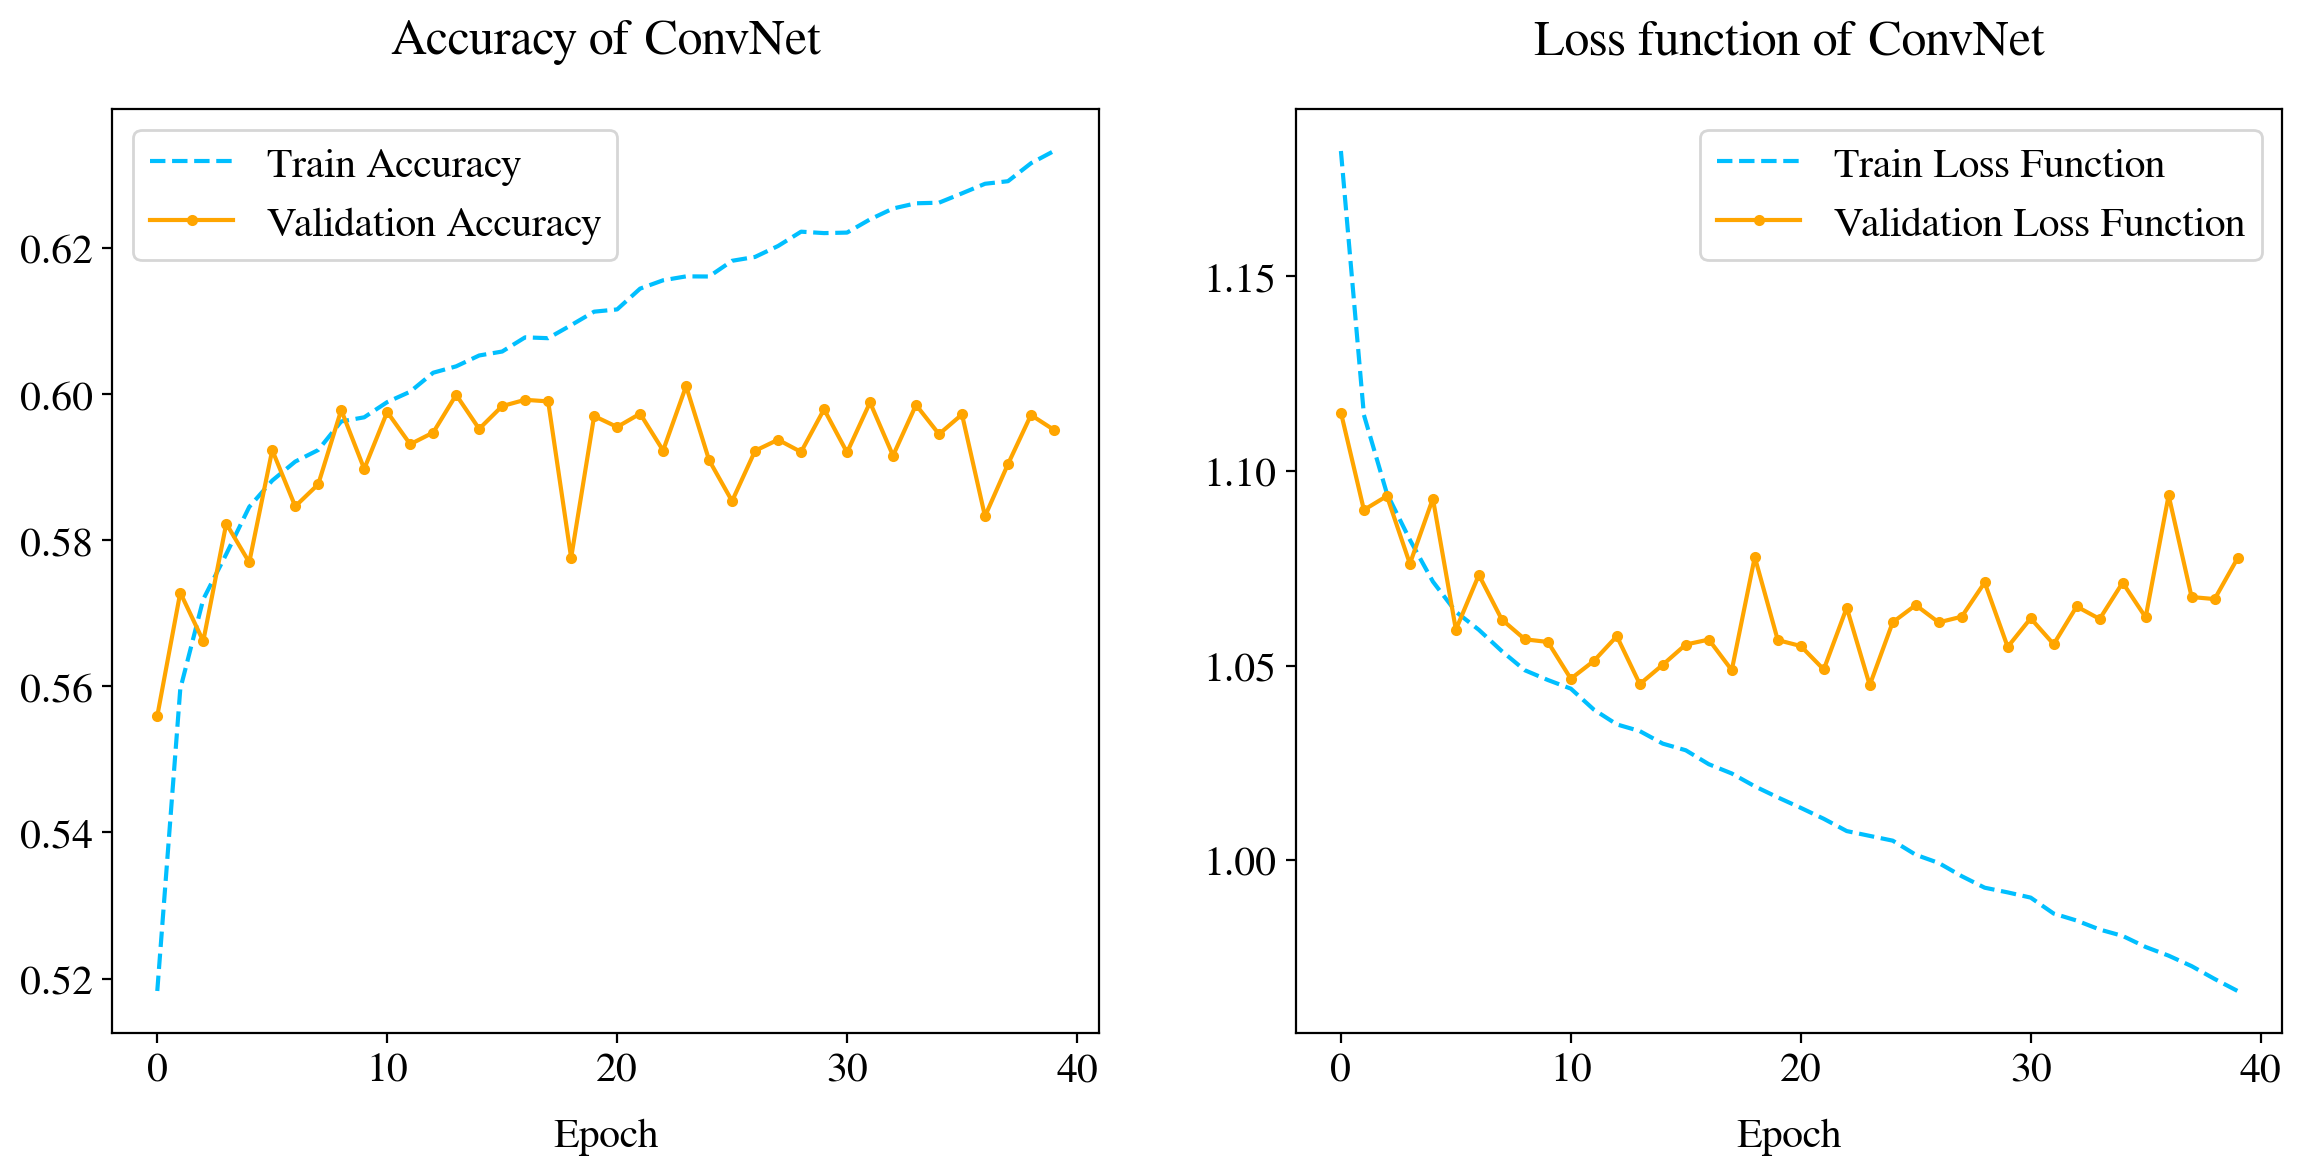

In [ ]:
#class instantiation
m = ModelEval(model2, X_test, Y_test_onehot, model_str="ConvNet")

#methods calling
m.accuracy_loss(pd.DataFrame(history.history))

Confusion matrix of ConvNet


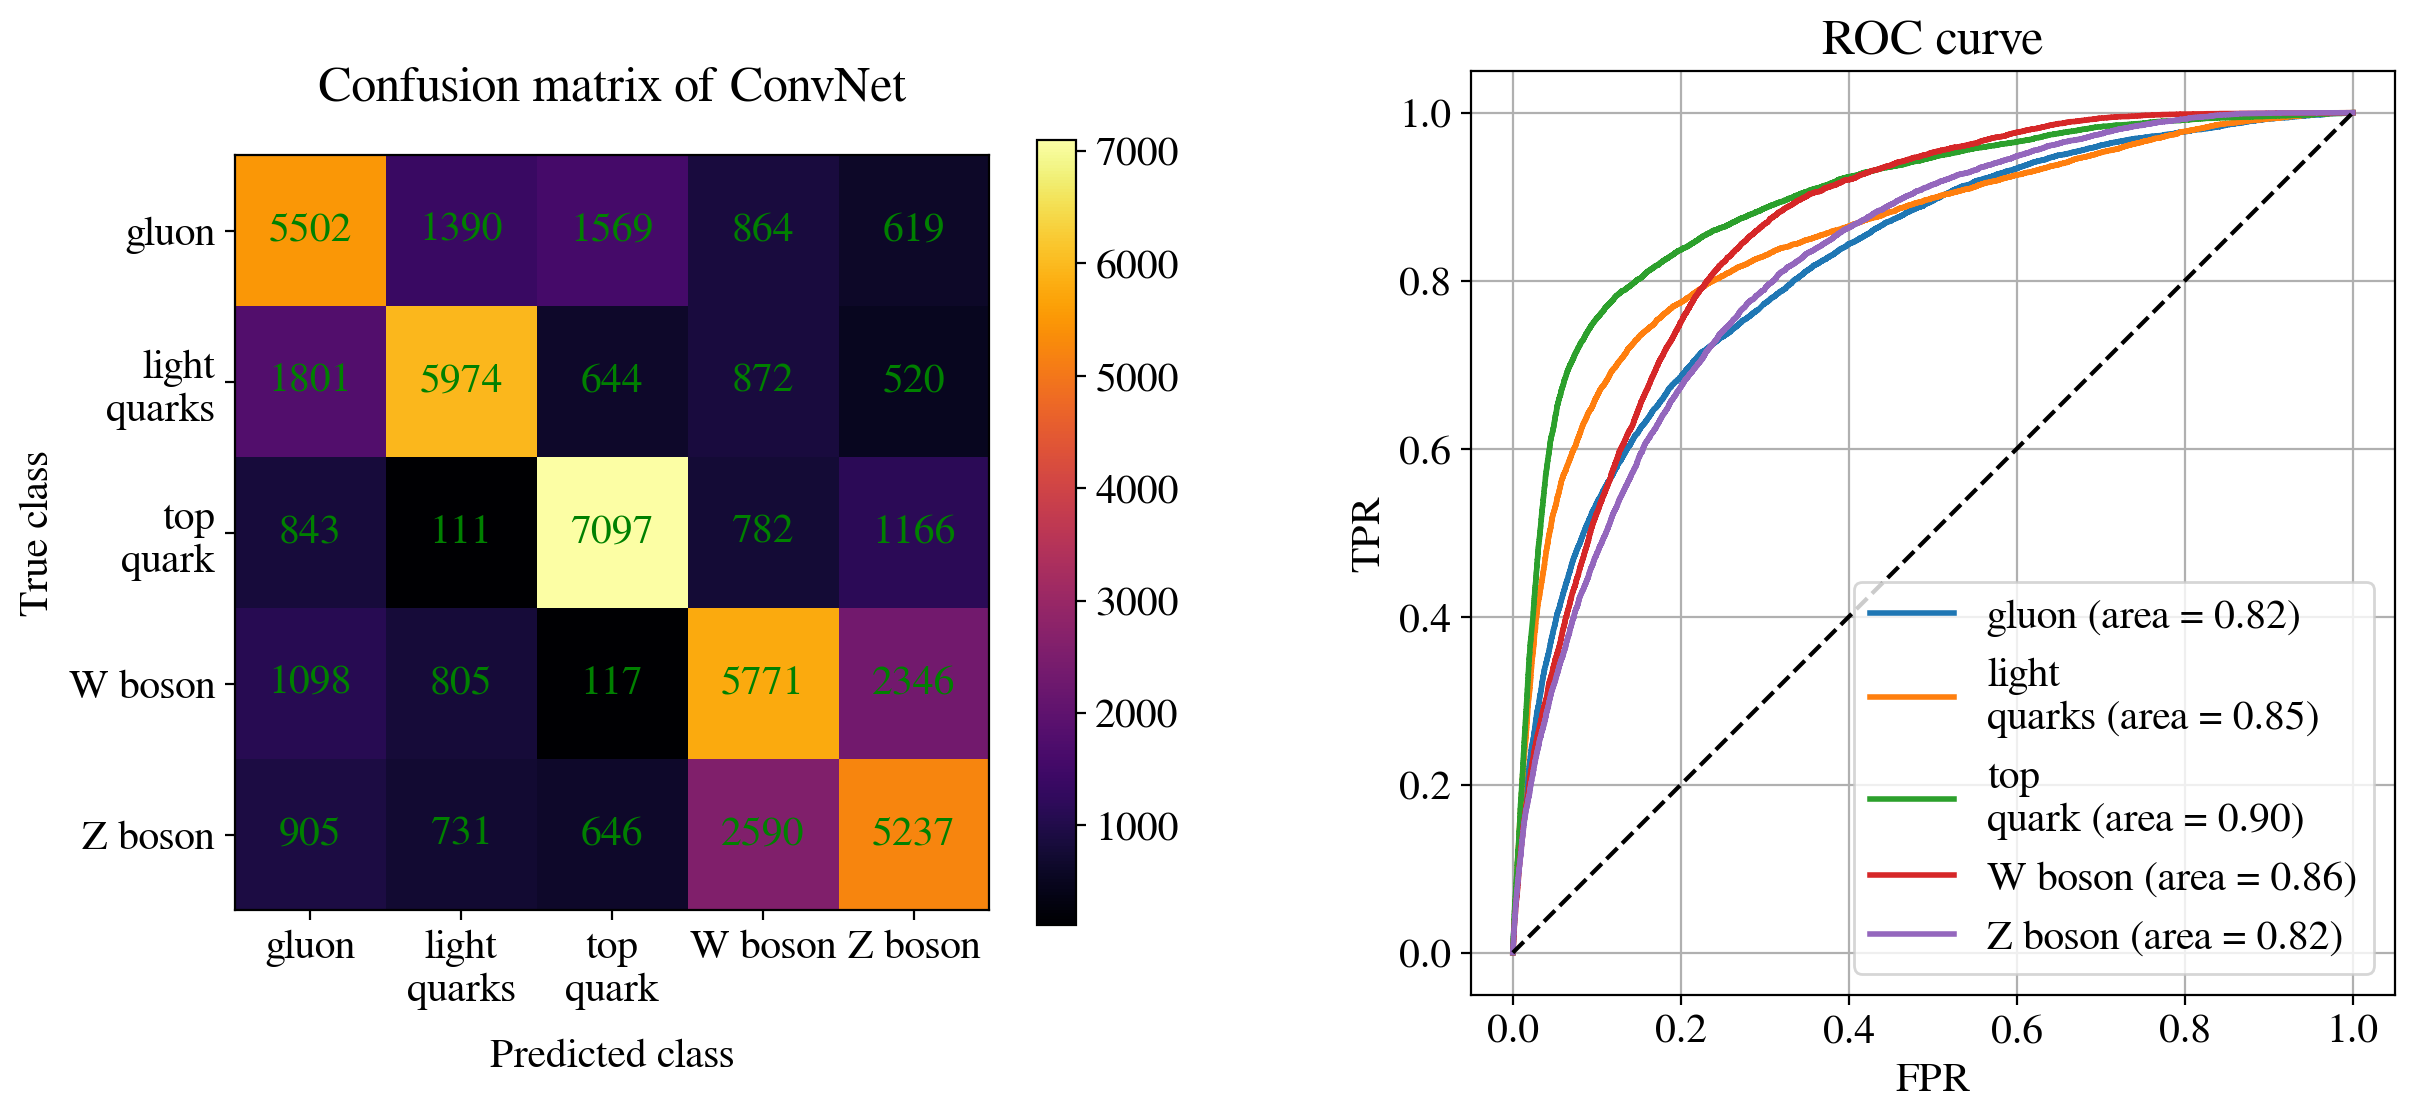

In [ ]:
m.Conf_Matrix_and_ROC_curve()

In [ ]:
# Evaluate the model
loss, accuracy = model2.evaluate(X_test, Y_test_onehot, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 1.0811
Test Accuracy: 0.5916
